In [2]:
import picCatTrainSet
import warnings

warnings.filterwarnings("ignore")
batch_size = 256
train_iter, test_iter = picCatTrainSet.load_data_fashion_mnist(batch_size)

In [3]:
import paddle
num_inputs = 784
num_outputs = 10

W = paddle.normal(0, 0.01, shape=(num_inputs, num_outputs))
b = paddle.zeros(shape=(num_outputs,))
W.stop_gradient=False
b.stop_gradient=False

In [4]:
def softmax(X):
    X_exp = paddle.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [19]:
X = paddle.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(Tensor(shape=[2, 5], dtype=float32, place=Place(gpu:0), stop_gradient=True,
        [[0.04233415, 0.07614716, 0.34170249, 0.09057378, 0.44924241],
         [0.06727842, 0.15383591, 0.09128407, 0.21785671, 0.46974489]]),
 Tensor(shape=[2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
        [1., 1.]))

In [6]:
def net(X):
    return softmax(paddle.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [20]:
def cross_entropy(y_hat, y):
    return - paddle.log(y_hat[[i for i in range(len(y_hat))], y.squeeze()])

In [7]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    if len(y_hat.shape) < len(y.shape):
        cmp = y_hat.astype(y.dtype) == y.squeeze()
    else:
        cmp = y_hat.astype(y.dtype) == y
    return float(cmp.astype(y.dtype).sum())

In [8]:
from LinerRegression.picCatTrainFromZeroUtils import Accumulator


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, paddle.nn.Layer):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with paddle.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, paddle.nn.Layer):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)

    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, paddle.optimizer.Optimizer):
            # 使用PaddlePaddle内置的优化器和损失函数
            updater.clear_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [26]:
from LinerRegression.Animator import Animator


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [33]:
from LinerRegression.linerRegressionSimpleUtils import sgd

lr = 0.2

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

AssertionError: 0.7393282594045003

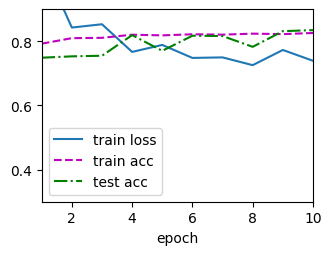

In [32]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)